In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from helper import *

dirs = [d for d in os.listdir() if d.startswith('outdir_') if '.' not in d if 'class' not in d]

classes = [d for d in os.listdir() if d.startswith('outdir_') if '.' not in d if 'class' in d]
dirs.sort()
classes.sort()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in square


[nan nan]
outdir_new_opt_competing2_MM0_useF1_False
[nan nan]
outdir_new_opt_competing2_MM0_useF1_False
[184.97573461 156.30943014]
outdir_new_opt_competing2_MM0_useF1_False
[184.97573461 156.60120949]
outdir_new_opt_competing2_MM0_useF1_False
[nan nan]
outdir_new_opt_competing2_MM0_useF1_True
[nan nan]
outdir_new_opt_competing2_MM0_useF1_True
[ 85.75506546 144.50503314]
outdir_new_opt_competing2_MM0_useF1_True
[ 83.74331424 134.64410702]
outdir_new_opt_competing2_MM0_useF1_True
[  39.69885426 9042.19525712]
outdir_new_opt_competing2_MM1_useF1_False
[  34.60298307 9027.86316529]
outdir_new_opt_competing2_MM1_useF1_False
[174.02078074 332.87983965]
outdir_new_opt_competing2_MM1_useF1_False
[170.42380212 304.74129908]
outdir_new_opt_competing2_MM1_useF1_False
[  39.69885426 9042.19525712]
outdir_new_opt_competing2_MM1_useF1_True
[  34.60298307 9027.86316529]
outdir_new_opt_competing2_MM1_useF1_True
[174.02078074 332.87983965]
outdir_new_opt_competing2_MM1_useF1_True
[170.42380212 304.741

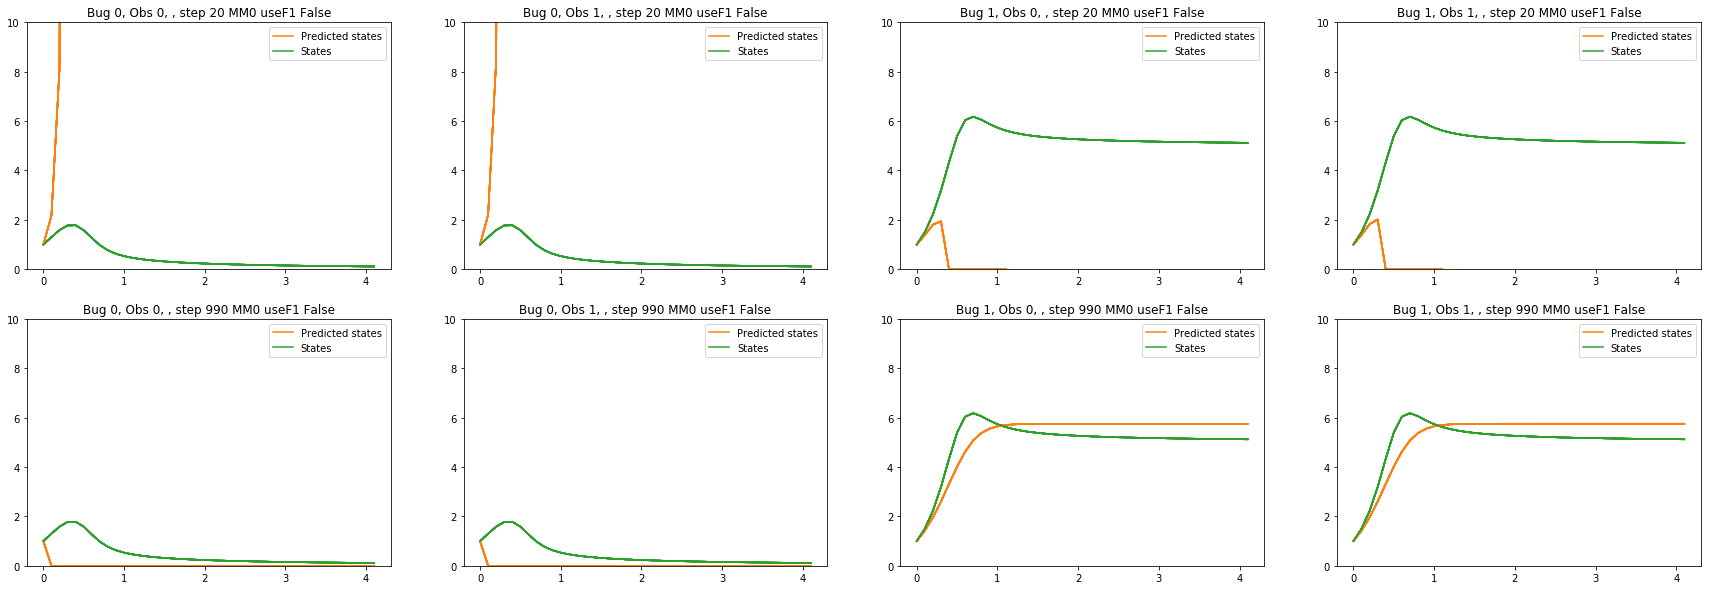

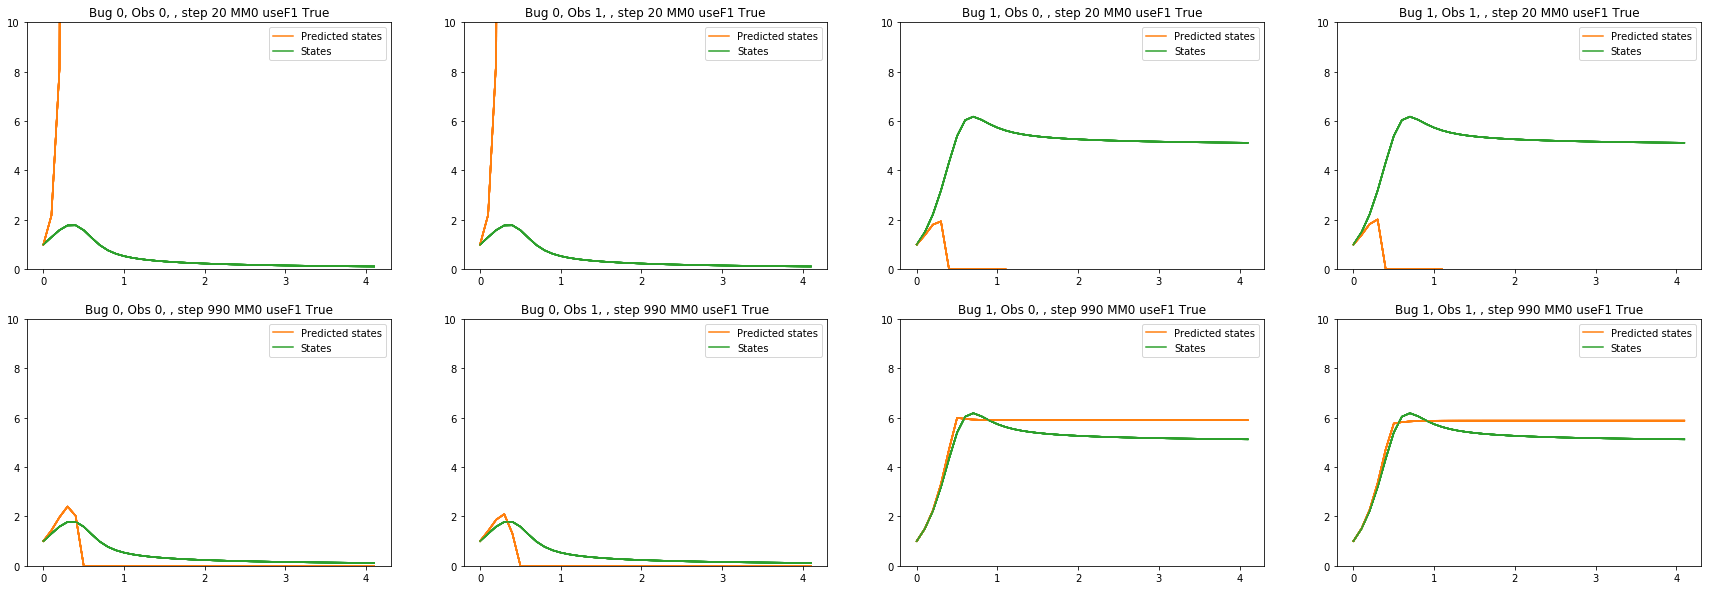

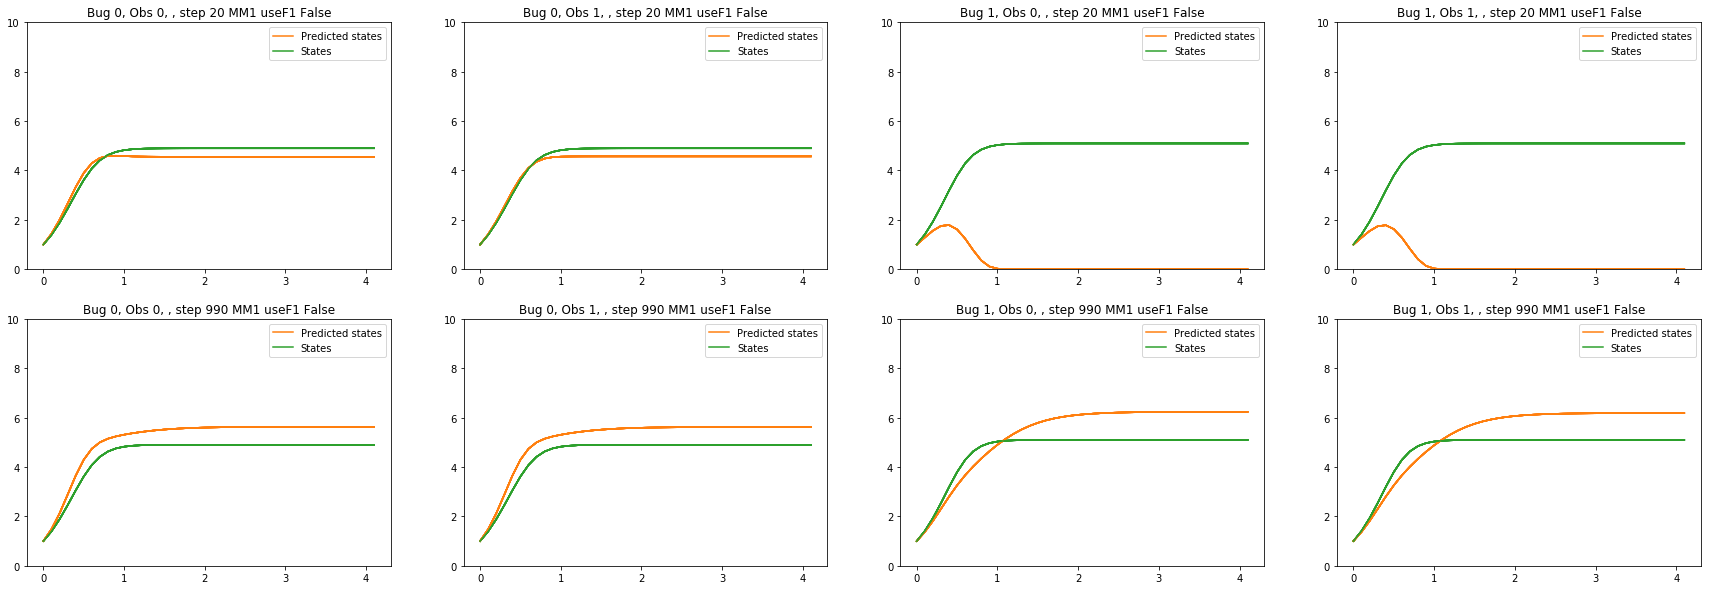

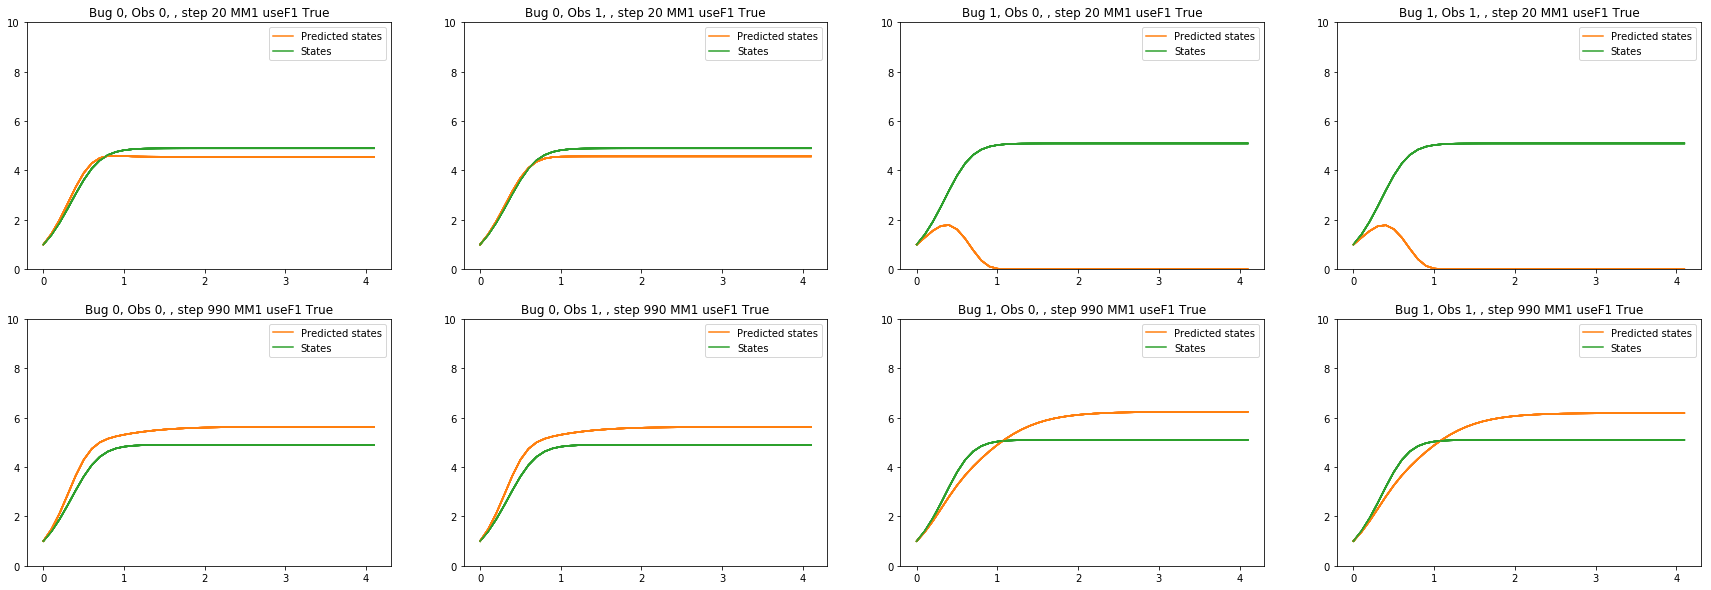

In [63]:
num_samps = 10
for i,d in enumerate(dirs):
    files = [fi for fi in os.listdir(d) if '.png' not in fi]
    files.sort()
    class_file = classes[i]
    
    if d.split('_')[3] != 'competing2':
        break
    
    fig,axes = plt.subplots(2,num_bugs*2,figsize = (30,10))
    for iif, f in enumerate([files[1], files[-1]]):
        with open(d + '/' + f,"rb") as pickle_in:
            trace_a, trace_b, trace_x, trace_f1,trace_f2, trace_beta = pickle.load(pickle_in)
        with open(class_file,"rb") as spl_in:
            spl = pickle.load(spl_in)
            
        use_mm = not (trace_b[0][0] == 1).all()
        
        tvec = np.arange(0,spl.time+2*spl.dt,spl.dt)
        num_bugs = trace_a[0][0].shape[0]
        for o in range(spl.num_mice):
            trace_a_mat = np.vstack([trace_a[k][o].flatten(order='F') for k in range(len(trace_a)-10,len(trace_a))])
            trace_b_mat = np.vstack([trace_b[k][o].flatten(order='F') for k in range(len(trace_a)-10,len(trace_a))])

            a_guess = np.mean(trace_a_mat,0)
            b_guess = np.mean(trace_b_mat,0)

            a_cov = np.cov(trace_a_mat.T)
            b_cov = np.cov(trace_b_mat.T)

            mse_error = np.zeros(2)
            for n in range(num_samps):
                try:
                    a_samp = np.reshape(st.multivariate_normal(a_guess, a_cov).rvs(),(num_bugs,num_bugs),order='F')
                except:
                    a_samp = np.reshape(st.multivariate_normal(a_guess, a_cov+1e-6*np.eye(len(a_guess))).rvs(),(num_bugs,num_bugs),order='F')
                if spl.use_mm == 0:
                    b_samp = np.ones(a_samp.shape)
                else:
                    try:
                        b_samp = np.reshape(st.multivariate_normal(b_guess, b_cov).rvs(),(num_bugs,num_bugs),order='F')
                    except:
                        b_samp = np.reshape(st.multivariate_normal(b_guess, b_cov+1e-6*np.eye(len(a_guess))).rvs(),(num_bugs,num_bugs),order='F')                
                    
                x,y = generate_data_MM(a_samp, b_samp, spl.gr,spl.xin,spl.dt,spl.use_mm,\
                                      spl.mvar[0][0],0,spl.num_mice,spl.num_states)
                
                xtrue, ytrue = generate_data_MM(spl.true_a, spl.true_b, spl.gr,spl.xin,\
                                                spl.dt,spl.use_mm,spl.mvar[0][0],0,spl.num_mice,spl.num_states)
                
                
                for b in range(num_bugs):
                    axes[iif,b*2+o].set_title('Bug ' + str(b)+', Obs ' + str(o) + ', ' + ', step '+ f.split('_')[-1] + ' ' +d.split('_')[4] + ' '+ d.split('_')[5] + ' '+ d.split('_')[6])
                    if n==0:
                        axes[iif,b*2+o].plot(tvec, x[o][:,b], label = 'Predicted states',color='C1')
                        axes[iif,b*2+o].plot(tvec, xtrue[o][:,b],label = 'States',color='C2')
                    else:
                        axes[iif,b*2+o].plot(tvec, x[o][:,b],color='C1')
                        axes[iif,b*2+o].plot(tvec, xtrue[o][:,b],color='C2')
                    axes[iif,b*2+o].set_ylim([0,10])
                    axes[iif,b*2+o].legend()
                
                    mse_error[b] += np.sum((x[0][:,b]-xtrue[0][:,b])**2)
#                 import pdb; pdb.set_trace()
            print(mse_error)
            fig.show()
            print(d)
                #         x,y = generate_data_MM()

In [33]:
spl.mvar

array([[0.1, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.1, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.1, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.1, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.1, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.1]])

In [30]:
spl.xin[0].shape

(1, 2)

In [26]:
np.linalg.inv(a_cov + np.eye(4))
np.linalg.inv(b_cov)

LinAlgError: Singular matrix

In [27]:
b_cov

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])